# Who is being left out by public transport?
**An analysis of public transport quality and accessibility in Santiago, Chile**

**[Iacopo Garizio](https://iacopogarizio.com)**

___

## Methodology
1. A
2. B
3. C

## Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

import random
import zipfile

## 1. Simulating the population on each city block
Because the census data has only information at a city block level, I simulate the position of each person inside each city block (keeping a margin from the border of the block).

### Loading the census data
Loading the census data and also filtering it using the region name ("REGIÓN METROPOLITANA DE SANTIAGO") and by coordinates.

In [3]:
blocks = gpd.read_file("zip://./data/chile_city_blocks.zip")
blocks.to_crs("EPSG:4326", inplace=True)

blocks = blocks[blocks.REGION == 'REGIÓN METROPOLITANA DE SANTIAGO'].copy()

##################################################
blocks = blocks[blocks.COMUNA == 'ÑUÑOA'].copy()
##################################################

blocks = blocks.cx[-70.8:70.4,-33.6:-33.3].copy()

In [4]:
def generate_random_points(polygon, n):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    while len(points) < n:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
    
    return points

def concat_gdf_list(gdf_list):
    crs = gdf_list[0].crs
    concat_df = pd.concat(random_points_list, ignore_index=True)
    return gpd.GeoDataFrame(concat_df, crs=crs)

### Simulating the points
The code rescales each city block by 90% to make points lay inside a small border in each city block.
Each set of points (for each city block) is saved as a GeoDataFrame.

In [5]:
scale_factor = 0.9

blocks['scaled_geometry'] = blocks.scale(scale_factor, scale_factor, scale_factor)
random_points_list = []

for block in blocks.itertuples():
    random_points = generate_random_points(block.scaled_geometry, block.TOTAL_PERS)
    gdf_random_points = gpd.GeoDataFrame(geometry=random_points, crs="EPSG:4326")
    gdf_random_points['FID'] = block.FID
    
    random_points_list.append(gdf_random_points)

random_population = concat_gdf_list(random_points_list)
random_population.index.name = 'person_id'

#### Visualizing of some of the randomized points

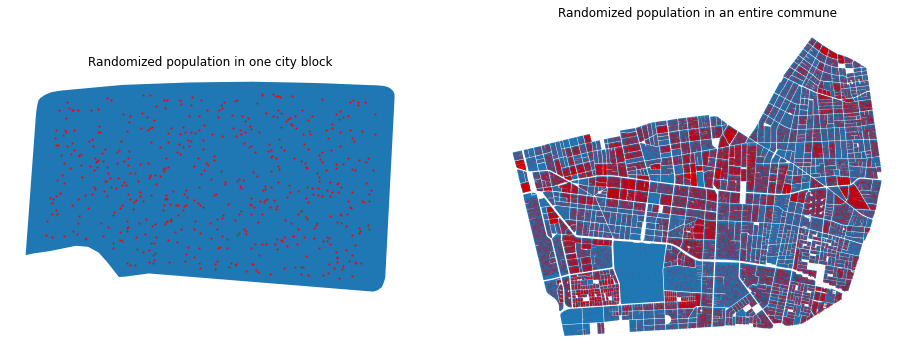

In [5]:
sel_commune = "ÑUÑOA"
sel_block_FID = 24146

block_example = blocks[blocks.FID == sel_block_FID]
random_population_block_example = random_population[random_population.FID == sel_block_FID]
commune_example = blocks[blocks.COMUNA == sel_commune]
random_population_commune_example = random_population[random_population.FID.isin(commune_example.FID)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

block_example.plot(ax=ax1)
random_population_block_example.plot(ax=ax1, markersize=1, color='r')

commune_example.plot(ax=ax2)
random_population_commune_example.plot(ax=ax2, markersize=0.001, color='r')

ax1.set_title("Randomized population in one city block")
ax2.set_title("Randomized population in an entire commune")

ax1.axis('off')
ax2.axis('off')
plt.show()

## Process GTFS data
This part of the code loads and extracts useful features from the GTFS files.

#### 4.2.2 Loading the GTFS data
The code reads the files *stops.txt*, *trips.txt*, and *stop_times.txt*. It then filters the trips that occur in working days (by doing "service_id == 'L'"). It then uses this information to filter stop_times (this means that we will only get stop_times that happen on working days). The code then counts the number of buses and the number of unique routes that pass through each stop. These two measures are going to be used as a proxy for quality, where a higher number of buses or routes imply better quality.

In [37]:
zf = zipfile.ZipFile("./data/santiago_gtfs.zip")

stops_df = pd.read_csv(zf.open('stops.txt'))
trips_df = pd.read_csv(zf.open('trips.txt'))
stop_times_df = pd.read_csv(zf.open('stop_times.txt'))

trips_working_day = trips_df[trips_df.service_id == 'L'].copy()
trips_working_day_id = trips_working_day.trip_id.unique()

stop_times_df_working_day = stop_times_df[stop_times_df.trip_id.isin(trips_working_day_id)].copy()
stop_n_buses = stop_times_df_working_day.groupby('stop_id').size().reset_index(name="n_buses")

stop_trips = pd.merge(trips_working_day, stop_times_df_working_day, on='trip_id', how='left')
stop_routes = stop_trips.groupby('stop_id').route_id.apply(np.unique).reset_index(name="routes")

stops_df = pd.merge(stops_df, stop_n_buses, on='stop_id', how='left')
stops_df = pd.merge(stops_df, stop_routes, on='stop_id', how='left')

#### 4.2.3 Merging the information and filtering
This part merges the information from the *stops.txt* file and the features extracted above. It then filters the stops by using the general shape (this is obtained by applying a buffer and then a unary union) of the city blocks of Santiago.


|Combination of randomized points and GTFS stops in one county/commune |
|:-------------------------:|
| ![](./images/random_population_county_gtfs.png)  |

In [38]:
stops = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat), crs='EPSG:4326')
stops.drop(columns=['stop_code', 'stop_lat', 'stop_lon', 'stop_url'], inplace=True)

stgo = blocks.to_crs("EPSG:3857").buffer(100).to_crs("EPSG:4326").unary_union
stops = stops[stops.within(stgo)].copy()

### Visualizing bus stops and metro stations

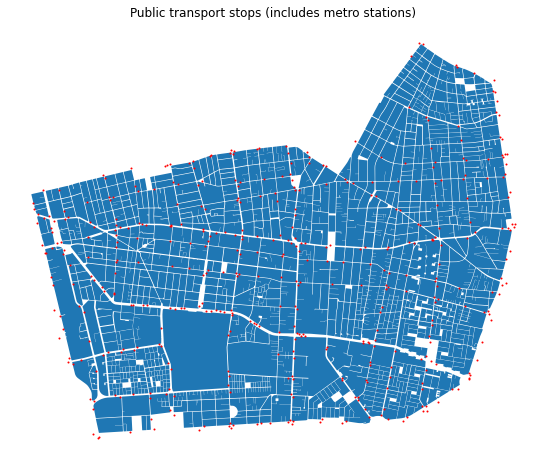

In [39]:
fig, ax = plt.subplots(1, figsize=(16, 8))

blocks.plot(ax=ax)
stops.plot(ax=ax, markersize=1, color='r')

plt.title("Public transport stops (includes metro stations)")
ax.axis('off')
plt.show()

### 4.3 Obtaining access and quality measures

In [40]:
def haversine_distance(point_1, point_2):
    """
    Reference: https://stackoverflow.com/a/29546836/7657658
    """
    lon1, lat1 = point_1.x.values, point_1.y.values
    lon2, lat2 = point_2.x.values, point_2.y.values
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km


def get_nearest_stops(points, stops, k):
    points = points.copy()
    stops = stops.copy()
    points_coordinates = list(zip(points.geometry.x, points.geometry.y))
    stops_coordinates = list(zip(stops.geometry.x, stops.geometry.y))
    btree = cKDTree(stops_coordinates)
    if k != 1:
        dist, idx = btree.query(points_coordinates, n_jobs=-1, k=k)
    else:
        dist, idx = btree.query(points_coordinates, n_jobs=-1, k=[1])  # Prevents dimentional squeeze

    points_nearest_stops_dfs = []

    for k_i in range(k):
        stops_close_ki = stops.iloc[idx[:,k_i]].reset_index(drop=True).copy()
        stops_close_ki.rename(columns={'geometry': 'stop_geometry'}, inplace=True)
        points_nearest_stops = pd.concat([points.reset_index(), stops_close_ki], axis=1)

        points_nearest_stops['distance_rank'] = k_i
        points_nearest_stops['distance_km'] = haversine_distance(points_nearest_stops.stop_geometry, points_nearest_stops.geometry)
        points_nearest_stops_dfs.append(points_nearest_stops)

    return pd.concat(points_nearest_stops_dfs).reset_index(drop=True)


def plot_map(gdf, color_column, vmin, vmax, cmap='coolwarm', figsize=(16, 8)):
    fig, ax = plt.subplots(1, figsize=figsize)
    gdf.plot(ax=ax, column=color_column, cmap=cmap, legend=True, vmin=vmin, vmax=vmax)
    ax.axis('off')
    plt.show()
    
    
# def get_nearest_stops(points, stops, k):
#     points = points.copy()
#     stops = stops.copy()
#     points_coordinates = list(zip(points.geometry.x, points.geometry.y))
#     stops_coordinates = list(zip(stops.geometry.x, stops.geometry.y))
#     btree = cKDTree(stops_coordinates)
#     if k != 1:
#         dist, idx = btree.query(points_coordinates, n_jobs=-1, k=k)
#     else:
#         dist, idx = btree.query(points_coordinates, n_jobs=-1, k=[1])  # Prevents dimentional squeeze
    
#     nearest_stop_dfs = []
    
#     for k_i in range(k):
#         stops_close_ki = stops.iloc[idx[:,k_i]].copy()

#         stops_close_ki['distance'] = haversine_distance(stops_close_ki.geometry, points.geometry)
#         stops_close_ki.rename(columns=lambda x: f"s{k_i}_{x}", inplace=True)
#         nearest_stop_dfs.append(stops_close_ki.reset_index(drop=True))
            
#     return pd.concat(nearest_stop_dfs, axis=1)

#### Obtaining the nearest 10 stops for the random points generated
This code uses the random population generated in section 3.1 and searches for the nearest three stops for each point. It then joins this information into a single dataset.

In [41]:
pop_nearests_stops = get_nearest_stops(random_population, stops, k=5)

# nearest_stops = get_nearest_stops(random_population, stops, k=10)
# random_population_stops = pd.concat([random_population.reset_index(), nearest_stops], axis=1).set_index('index')

#### 4.3.2 Obtaining new metrics and aggregating data
For each point, it calculates two new metrics *sum_n_buses*, which is the sum of the buses that pass through the nearest 3 stops (if they are within 200m). It does the same for *sum_n_routes* (with the same condition of 200m).
As for the aggregations, for each city block, the code calculates the mean distance to the nearest stops and the mean of *sum_n_buses* and *sum_n_routes*. Finally, it merges the original GeoDataFrame containing each city block with this new information.

In [ ]:
dist_max = 0.2

distance_metrics = random_population_stops.groupby("FID").s0_distance.agg(mean_distance='mean', summed_distance='sum')

buses_count = random_population_stops.copy()
buses_count['sum_n_buses'] = buses_count.s0_n_buses * (buses_count.s0_distance < dist_max) + \
                             buses_count.s1_n_buses * (buses_count.s1_distance < dist_max) + \
                             buses_count.s2_n_buses * (buses_count.s2_distance < dist_max)
buses_metrics = buses_count.groupby("FID").sum_n_buses.mean()

routes_count = random_population_stops.copy()
routes_count['sum_n_routes'] = routes_count.s0_n_routes * (routes_count.s0_distance < dist_max) + \
                               routes_count.s1_n_routes * (routes_count.s1_distance < dist_max) + \
                               routes_count.s2_n_routes * (routes_count.s2_distance < dist_max)
routes_metrics = routes_count.groupby("FID").sum_n_routes.mean()

blocks_transit = blocks.copy()
blocks_transit = pd.merge(blocks_transit, distance_metrics.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, buses_metrics.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, routes_metrics.reset_index(), on='FID', how='left')

In [42]:
pop_nearest_stop = pop_nearests_stops[pop_nearests_stops.distance_rank == 0]
mean_dist_nearest = pop_nearest_stop.groupby('FID').distance_km.agg(mean_distance_nearest='mean', summed_distance_nearest='sum')

In [43]:
mean_dist_k_nearests = pop_nearests_stops.groupby('FID').distance_km.mean().to_frame(name="mean_distance_k_nearest")

In [44]:
dist_max = 0.2

pop_close_stops = pop_nearests_stops[pop_nearests_stops.distance_km <= dist_max]

sum_n_buses_close = pop_close_stops.groupby(['FID', 'person_id'], as_index=False).n_buses.sum()
mean_sum_n_buses_close = sum_n_buses_close.groupby('FID').n_buses.mean().to_frame(name="mean_sum_n_buses")

In [18]:
pop_close_stops['routes_l'] = pop_close_stops.routes.apply(list)

In [87]:
combined_routes_close = pop_close_stops.iloc[:1000].groupby(['FID', 'person_id']).routes.sum()
unique_routes_close = combined_routes_close.apply(lambda x: np.unique(x)).reset_index(name="close_routes")
unique_routes_close['n_unique_routes'] = unique_routes_close.close_routes.apply(len)
mean_n_unique_routes_close = unique_routes_close.groupby('FID').n_unique_routes.mean().to_frame(name="mean_n_unique_routes_close")

In [108]:
combined_routes_close

FID    person_id
22281  0                                  D16
       1                                  D16
       2                                  D16
       3                                  D16
       4                                  D16
                              ...            
22284  1130         [104, 114, 212, 224, 325]
       1131         [104, 114, 212, 224, 325]
       1132         [104, 114, 212, 224, 325]
       1133         [104, 114, 212, 224, 325]
       1134         [104, 114, 212, 224, 325]
Name: routes, Length: 1000, dtype: object

In [102]:
combined_routes_close.apply(lambda x: )

FID    person_id
22281  0            None
       1            None
       2            None
       3            None
       4            None
                    ... 
22284  1130         None
       1131         None
       1132         None
       1133         None
       1134         None
Name: routes, Length: 1000, dtype: object

<AxesSubplot:>

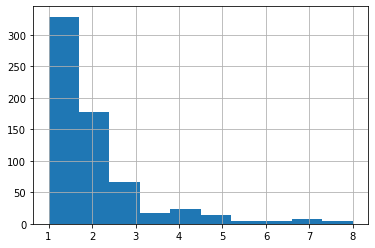

In [76]:
mean_n_unique_routes_close.mean_n_unique_routes_close.hist()

In [1]:
x = pop_close_stops.routes.apply(list)

NameError: name 'pop_close_stops' is not defined

In [ ]:
x.sum()

In [123]:
pop_close_stops.groupby(['FID', 'person_id'], as_index=False).apply(lambda x: set.union(*x.routes))

ValueError: 1 columns passed, passed data had 21 columns

In [105]:
pop_close_stops.routes.apply()

TypeError: operands could not be broadcast together with shapes (3,) (12,) 

In [84]:
mean_sum_n_buses

,mean_sum_n_buses
FID,
22281,16.937500
22282,9.000000
22283,56.828571
22284,28.287770
22285,9.000000
...,...
24276,29.891892
24277,61.591549
24278,16.115578


<AxesSubplot:>

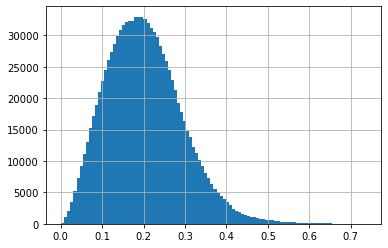

In [40]:
pop_nearests_stops.distance_km.hist(bins=100)

___

### 5. Findings

I wanted to evaluate two types of metrics: Access-based and quality-based. For each type, I calculated two different metrics.
- Accessibility: Uses the idea of the distance to the nearest stops.
- Quality: Uses the idea that a higher number of buses and a higher number of routes imply better quality.

### 5.1 Accessibility
This part uses the columns *mean_distance* and *summed_distance* generated in section 4.3.2.

#### 5.1.1 Mean distance
Plots the column *mean_distance* for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. The graph shows how the outskirts of the city have the highest mean distance to the nearest stop. This is especially a problem for the population in the east and south-east parts of the city as their reliance on public transport is higher than, for example, the population in the north-east part.

In [ ]:
var_name = 'mean_distance'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax)

#### 5.1.1 Summed distance
Plots the column *summed_distance* for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. The graph shows how the outskirts of the city and various specific places in the middle of the city have the highest summed distance to the nearest stop.

In [ ]:
var_name = 'summed_distance'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax)

### 5.2 Quality
This part uses the columns *sum_n_buses* and *sum_n_routes* generated in section 4.3.2.

#### 5.2.1 Number of buses
Plots the column sum_n_buses for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. As for the colors, it uses a reversed *coolwarm* palette. The graph shows how the outskirts of the city have the lowest summed number of buses nearby. This also shows that the places with the best quality of public transport (according to this type of measure), are close to the main roads and highways of the city. This is a problem especially for the population in lower-income and low car-usage parts of the city, as they rely mostly on public transport.

In [ ]:
var_name = 'sum_n_buses'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax, cmap='coolwarm_r')

#### 5.2.2 Number of bus routes
Plots the column sum_n_routes for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. As for the colors, it uses a reversed *coolwarm* palette. The graph shows how the outskirts of the city have the lowest summed number of unique bus routes nearby. This also shows that the places with the best quality of public transport (according to this type of measure), are close to main roads and highways.  
This graph is almost equal to the one generated by *sum_n_buses* suggesting that there is not much difference between the two metrics.

In [ ]:
var_name = 'sum_n_routes'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax, cmap='coolwarm_r')

## 6. Discussion

### 6.1 Limitations

- This analysis uses a direct path to calculate the distance between each point and its nearby stops, but in reality, this path might be different.
- Because of the lack of a granular dataset, I simulated the position of each person in the city inside each city block using a uniform distribution. This is an assumption and might not reflect correctly the real world. As mitigation, I ran multiple simulations and obtained almost the same results every time.

### 6.2 Implications

The findings suggest that there are groups of people in the city that are being consistently left out, no matter what metric we use. These groups of people live mainly in the outskirts of the city, especially on the east side. This means that future additions of bus stops and metro stations should consider this information in order to benefit these groups. Also, current routes could be rearranged to lessen the current disparity.

## 7. Conclusion

This analysis has shown that the response to the question **Who is being left out by public transport?** depends on what we understand by *being left out*. If we consider *left out* as having a high distance to the nearest bus stop, we see that the outskirts of the city, especially the east-side are the most underserved. If we know consider *left out* as having a low number of buses or routes passing through the nearest stops, then the only areas well-served are the ones near main roads.  
However, despite the differences in the results obtained by each metric, there is one group that is constantly shown as having the worse quality and accessibility: the outskirts of the city. Future public policies should focus on these areas.

## References

[1] López, A. (2019). Mapa de viajes en el Gran Santiago. Accessed December 14, 2020 from https://ariellopez.carto.com/builder/a802cafa-15ff-47e9-8c1c-7cb663d2d7a9/embed